# Transfer Entropy
#### Marc Brittain

The goal of this notebook is to introduce the transfer entropy tool that was devolped by Lizer and provide different examples of how it can be used. Recall that transfer entropy can tell you how much uncertainty is decreased in knowing the next state of system by know the current state of another system.

**Note:** To use the tool created by Lizer and to follow along with this notebook you must be running python 3. I am currently using one of the newer versions, python 3.6 and it is easy enough to create a new anaconda environment with the newest version.


To check which python environments are available go to the terminal an enter the following command:

----
```python
conda search python
```

----

Once this has completed scroll until you find the section that is explicitly named 'Python' and below it will list all versions that are avaiable for an anaconda environment.

To create a new evironement go back to the terminal and enter the following command:

----

```python
conda create --name EnvironmentNameHere python=3.6.1 
```

----

You can decide which version to install as long as it is a python 3 version. The environemnt name is up to your choosing as well. Once created you can then activate the enviroment from the terminal by using:

----
```python
source activate EnvironmentName
```

----

Then to run a jupyter notebook in this new environment

----

```python
jupyter notebook
```

----

At this point the new environemnt is set up but you will need to download the main packages:

* Matplotlib
* Numpy
* Scipy
* **Jpype**
* etc.

These packages are probably already installed but to make sure they are in the new environment, activate the environment and pip install each module. Also make sure to add the script file I included to the local directory of the notebook.

**Jpype will probably not pip install**

To install Jpype, I believe I had to download a new version of Javascript and then download the actual Jpype module on my computer. From there I went to my terminal and activated my environment and used 

----

```python
pip3 install jpype
```

----

This may work, it might not. I would mess around with it until it works. Their documentation was not great when I went through it so hopefully they updated it. 

From there the last thing to download is the toolbox from lizers github: https://github.com/jlizier/jidt

Unzip the folder and move it to your location of choice. It is easiest to move the folder into your pwd of where your notebook is as you have to navigate to a certain file in the folder. 

With this we are now ready to begin.

----



----



----



----

# Transfer Entropy on the Damped Driven Pendulum

$$\large\frac{d^2 \phi}{dt^2} +2\beta\frac{d\phi}{dt} +\omega_o^2\sin\phi=\gamma\omega_o^2\cos(\omega t)$$

In this example I will run transfer entropy on the Damped Driven Pendulum. I will start by using a continuous method for the first example and then for the second example I am going to convert the time series into a binary state of:
* 1 : increasing
* 0 : decreasing

This way we can utilize different aspects of the tool.

In [1]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from CAtransferEntropy import *
import seaborn as sns
sns.set_context('notebook',font_scale=1.5)
sns.set_style('ticks')
from jpype import *
%matplotlib inline

In [2]:
# define constants


# small gamma value


gamma = .01
omega = 2*np.pi
omega_o = 1.5*omega
beta = omega_o/4

In [3]:
def deriv(z, t):
    
    phi, phidot = z
    
    return [phidot, -2*beta*phidot-omega_o**2*np.sin(phi)+gamma*omega_o**2*np.cos(omega*t)]

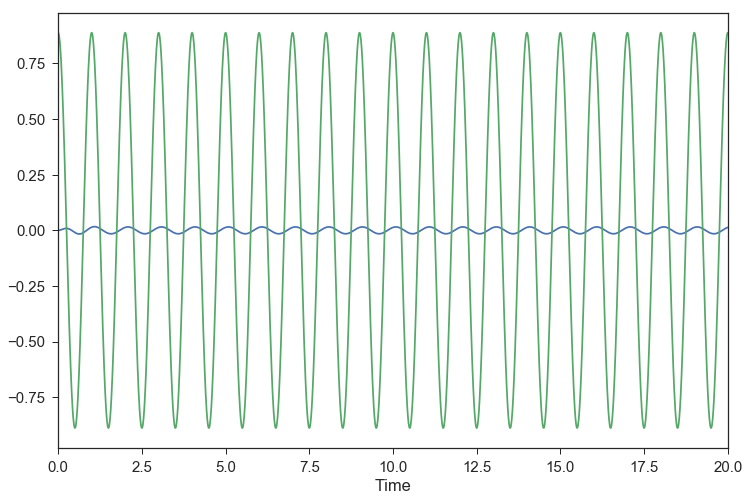

In [4]:
t = np.linspace(0, 20, 2000)
zinit = [0, 0]

# pendulum's position
X = integrate.odeint(deriv, zinit, t)

plt.figure(figsize=(12,8))
plt.plot(t,X[0:2000,0])
plt.plot(t,gamma*omega_o**2*np.cos(omega*t))
plt.xlabel('Time')
plt.xlim(t[0],t[-1])


# forcing function
f1 = gamma*omega_o**2*np.cos(omega*t)

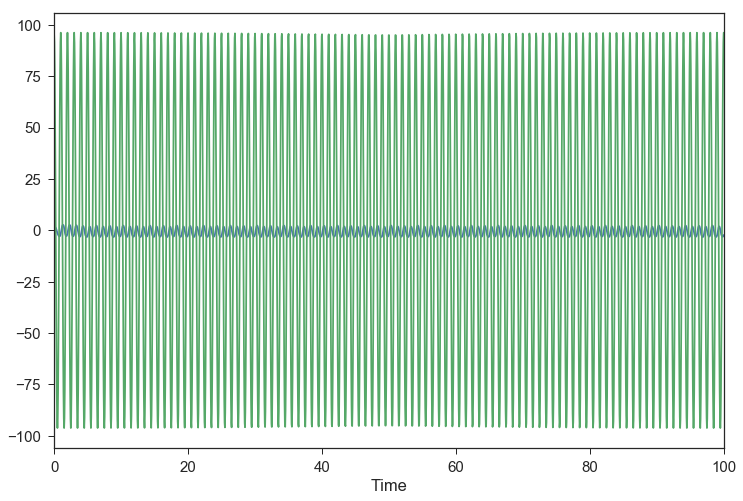

In [5]:
# Repeat with large gamma value

gamma=1.0829
t = np.linspace(0, 100, 2000)
zinit = [np.pi/2, 0]
z = integrate.odeint(deriv, zinit, t)


plt.figure(figsize=(12,8))
plt.plot(t,z[0:2000,0])
plt.plot(t,gamma*omega_o**2*np.cos(omega*t))
plt.xlabel('Time')
plt.xlim(t[0],t[-1])


f2 = gamma*omega_o**2*np.cos(omega*t)

We now have 2 different timeseries to run transfer entropy on and compare. For the small gamma value we can determine:
* Pendulum postion: X ----> forcing function: f1
* forcing function: f1 ----> pendulum posistion: X

Likewise for the large gamma value.

To do this we need to first start the JVM. What the JVM from Jpype does is that it takes your python code, converts it to java and runs the code in java. It then takes the results and converts it back to python code so that you can use it in your notebook. There are certain exceptions where the datatypes do not convert well and some are not allowed to be converted at all. For our purpose of converting either floats or integers we are safe. 

In [6]:
# navigate to the .jar file in the Lizer toolbox

jarlocation = "../../infodynamics-dist-1/infodynamics.jar"

startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path="+jarlocation)

## Make sure the above line is in a separate block of code. 
If you run the startJVM command and attempt to rerun it you will be greeted with an annoying error that is going to spit out a java log error into your directory and make you restart the notebook. I have not figured out a way to stop this problem even by using the shutdownJVM command that Jpype advices but I guess that is what happens when using python and java together.

You can however rerun anything below as many times and change whatever you need.

In [7]:
# Below I am opening the continous kraskov class into python as a java package and importing the
# transfer entropy calculator.

teCalcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
teCalc = teCalcClass();

Next, I am going to calculate the transfer entropy for the small and large gamma values as a function of nearest neighbors. 

Before getting to the code, I am going to copy the main function from the for-loop below to explain what is going on. 

----
```python
teCalc.initialise(1)
teCalc.setProperty("k", str(i))
teCalc.setObservations(X[0:2000,0],f1)
teP_To_F_lowG.append(teCalc.computeAverageLocalOfObservations())
```

----


First we see the **.initialise** call. This call **has** to be implemented each time you are making a transfer entropy calculation as it resets the calculator and will allow for new data. Otherwise you will have observations from other data that won't provide the correct result.

**.initialise** also accepts different arguments depending if you are using the continuous or discrete transfer entropy calculator. Since we are using the continuous, **.initialise** accepts 5 arguments.

----

```python
.initialise(k_history, lag_k, l_history, lag_l, lag)
```

----

I honestly forget what the last argument is but it is somewhere in one of the pdf's included in Lizer's tool. 
For this example below we are setting all arguments == 1 by default.


Next we have **.setProperty("k", str(nneighbor))**

make sure the inputs to **.setProperty** are strings.

**.setProperty(string, string)**

The "k" is saying that we are using the kraskov estimater and the second input is saying how many nearest neighbors to use in the calculation.

**.setObservations(X[0:2000,0],f1)** is where you input the data for the transfer entropy calculation. The format for **.setObservations()** is 

----

```python
.setObservations(X, Y)
```


----

where you are calculating TE(X-->Y)



The final argument, **.computeAverageLocalOfObservations( )**, does exactly what is says and returns the calculated transfer entropy value.

----


----

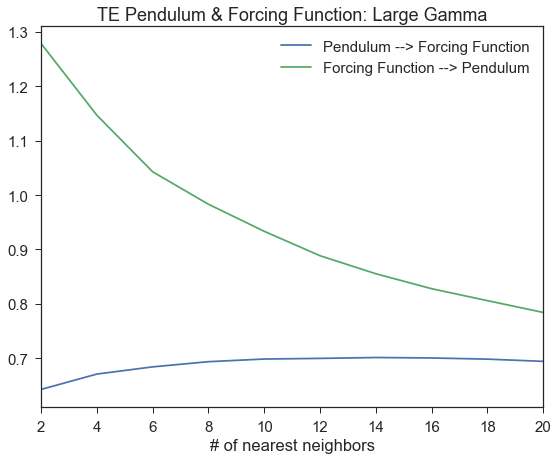

In [8]:
# create empty lists to store the TE values

#large gammma
teP_To_F_highG = []
teF_To_P_highG = []

#small gamma
teP_To_F_lowG = []
teF_To_P_lowG = []

nearest = []


for nneighbor in range(2,21,2):
    
    
    # lower gamma value    
    #################################################################
    
    # pendulum --> forcing function
    
    teCalc.initialise(1)
    teCalc.setProperty("k", str(nneighbor))
    teCalc.setObservations(X[0:2000,0],f1)
    teP_To_F_lowG.append(teCalc.computeAverageLocalOfObservations())
    
    # forcing function --> pendulum
    
    teCalc.initialise(1)
    teCalc.setProperty("k", str(nneighbor))
    teCalc.setObservations(f1,X[0:2000,0])
    teF_To_P_lowG.append(teCalc.computeAverageLocalOfObservations())
    #################################################################
    
    
    
    # high gamma value
    #################################################################
    
    # pendulum --> forcing function
    
    teCalc.initialise(1)
    teCalc.setProperty("k", str(nneighbor))
    teCalc.setObservations(z[0:2000,0],f2)
    teP_To_F_highG.append(teCalc.computeAverageLocalOfObservations())
    
    # forcing function --> pendulum
    
    teCalc.initialise(1)
    teCalc.setProperty("k", str(nneighbor))
    teCalc.setObservations(f2,z[0:2000,0])
    teF_To_P_highG.append(teCalc.computeAverageLocalOfObservations())
    #################################################################
    
    
    nearest.append(nneighbor)
    
    
# plotting the result

plt.figure(figsize=(9,7))
plt.plot(nearest, teP_To_F_highG)
plt.plot(nearest, teF_To_P_highG)
plt.xlim(nearest[0], nearest[-1])
plt.legend(['Pendulum --> Forcing Function','Forcing Function --> Pendulum'])
plt.title('TE Pendulum & Forcing Function: Large Gamma')
plt.xlabel('# of nearest neighbors')

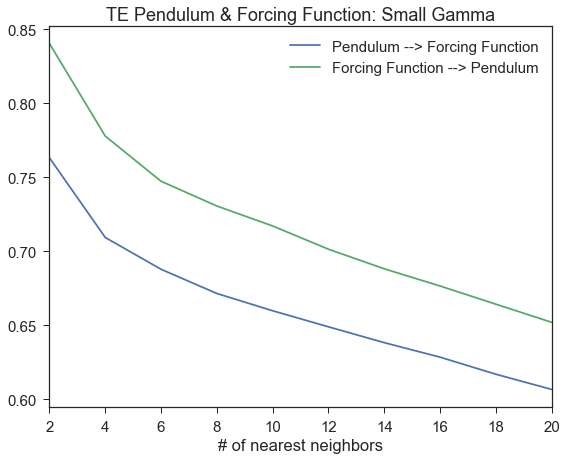

In [9]:
plt.figure(figsize=(9,7))
plt.plot(nearest, teP_To_F_lowG)
plt.plot(nearest, teF_To_P_lowG)
plt.xlim(nearest[0], nearest[-1])
plt.legend(['Pendulum --> Forcing Function','Forcing Function --> Pendulum'])
plt.title('TE Pendulum & Forcing Function: Small Gamma')
plt.xlabel('# of nearest neighbors')


----

#### Now lets convert the large gamma timeseries into binary states.

----

In [10]:
source = f1.copy()  # if you dont include .copy the code below will change f1

source = source[1:] - source[:-1]

source[(source == 0)] = 1 if np.random.rand() > 0.5 else 0
source[(source < 0)] = 0
source[(source > 0)] = 1

In [11]:
dest = X[:2000,0].copy()

dest = dest[1:] - dest[:-1]

dest[(dest == 0)] = 1 if np.random.rand() > 0.5 else 0
dest[(dest < 0)] = 0
dest[(dest > 0)] = 1

In [12]:
# Create a TE calculator and run it:

teCalcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
teCalc = teCalcClass(2,5)
teCalc.initialise()

Notice above we now have a call after teCalcClass that is (2,5) and now our **.initialise** is empty.

This is the main difference between the discrete and continuous calculation that you have to be careful of. In the discrete case you define your number of states, M and your K history, after teCalcClass. 

The number of states in a binary time series is 2: 0 or 1; and I definied the history length of K to be 5 in this example. 

----

----

This is where the true hand-wavyness shows up. For numpy arrays, we have to convert them to a list and then we are able to convert them into java arrays. 

It is straight forward by using, for example, our numpy array: source

----

```python
source_list = source.tolist()
```

----

Then from there we have to use the java wrapper: 

----

```python
JArray(JInt, 1)
```

----

where 1 is the dimension of source array.


----

You may wonder at this point, why didn't we have to do that earlier? To answer that question, I have no idea. If anything to wrap floats there is a call JDouble and JFloat and for some reason we did not have to use either of those. It may be because we were using the continuous method but that doesn't make a lot of sense. Regardless, it works so let's keep moving forward.

---

In [13]:
# convert to java array and calculate transfer entropy TE(forcing function -- > position)

sourceJArray = JArray(JInt, 1)(source.tolist())
destJArray = JArray(JInt, 1)(dest.tolist())
teCalc.addObservations(sourceJArray, destJArray)
teCalc.computeAverageLocalOfObservations()

0.04873197404228391

In [14]:
# run the TE (position --> forcing function)

# have to initialise since we are running a new calculation
teCalc.initialise()
teCalc.addObservations(destJArray, sourceJArray)
teCalc.computeAverageLocalOfObservations()

0.0033097677813781617

It turns out we were still able to show that the forcing function has  much more influence on the position than the position on the forcing function. It may be interesting to re-run this varying the different K history lengths.

We can also run the **local transfer entropy** for the time series and plot it through time. Let's calculate localTE(forcing function --> pendulum)

In [15]:
teCalc.initialise()
teCalc.addObservations(sourceJArray, destJArray)
localTE = teCalc.computeLocalFromPreviousObservations(sourceJArray,destJArray)

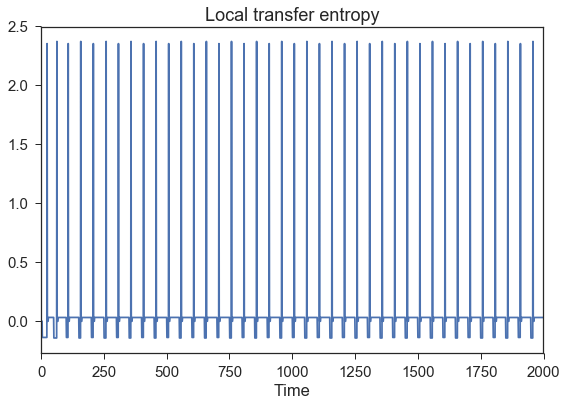

In [16]:
plt.figure(figsize=(9,6))
plt.plot(localTE)
plt.title('Local transfer entropy')
plt.xlim(0, len(localTE))
plt.xlabel('Time')

Turns out to be more interesting than expected. Sure enough if we take the mean of this local transfer entropy we arive back at the the value above.

Note that the variable **localTE** is still a java array and we need to convert back to a numpy array.

In [17]:
type(localTE)

jpype._jarray.double[]

In [18]:
localTEnp = np.array(localTE)
localTEnp.mean()

0.048610083161737955

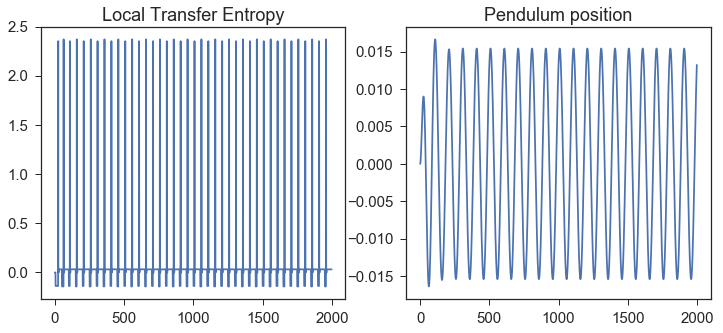

In [19]:
# plot the local transfer entropy with the pendulums position in time

fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
axs[0].plot(localTEnp)
axs[0].set_title('Local Transfer Entropy')
axs[1].plot(X[:2000,0])
axs[1].set_title('Pendulum position')

Just from a observation we can see that the local transfer entropy is negative periodically. Negative values are allowed and what they mean is that there is misinformation. Some further analysis may be able to show that when the pendulum changes direction, it results in this misinformation. 

In [20]:
localTEnp[:100]   # first 100 entries

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.13735893, -0.13735893, -0.13735893, -0.13735893, -0.13735893,
       -0.13735893, -0.13735893, -0.13735893, -0.13735893, -0.13735893,
       -0.13735893, -0.13735893, -0.13735893, -0.13735893, -0.13735893,
       -0.13735893, -0.13735893, -0.13735893, -0.13735893,  2.35190315,
        0.        ,  0.        ,  0.        ,  0.        ,  0.03206121,
        0.03206121,  0.03206121,  0.03206121,  0.03206121,  0.03206121,
        0.03206121,  0.03206121,  0.03206121,  0.03206121,  0.03206121,
        0.03206121,  0.03206121,  0.03206121,  0.03206121,  0.03206121,
        0.03206121,  0.03206121,  0.03206121,  0.03206121,  0.03206121,
        0.03206121, -0.14196819, -0.14196819, -0.14196819, -0.14196819,
       -0.14196819, -0.14196819, -0.14196819, -0.14196819, -0.14196819,
       -0.14196819, -0.14196819, -0.14196819,  2.37029112,  0.        ,
        0.        ,  0.        ,  0.        ,  0.03157008,  0.03

----

# Cellular Automata

----

The next example will be applying local transfer entropy to wolfram rule 110 and also wolfram rule 184. These cellular automata are both Elementary meaning they consist of 2 states: 0 and 1, so for this calculation we will use the discrete transfer entropy.

In [21]:
# 4 different wolfram rules. You can change which rule you want to run. I will be using 110 and 184 as mentioned above

RULES = {30: {"111": '0', "110": '0', "101": '0', "000": '0',
              "100": '1', "011": '1', "010": '1', "001": '1'},

         90: {"111": "0", "110": "1", "101": "0", "100": "1",
              "011": "1", "010": "0", "001": "1", "000": "0"},

         110: {"111": '0', "110": '1', "101": '1', "100": '0',
               "011": '1', "010": '1', "001": '1', "000": '0'},

         184: {"111": "1", "110": "0", "101": "1", "100": "1",
               "011": "1", "010": "0", "001": "0", "000": "0"}
         }

In [22]:
rule_110 = RULES[110]
rule_184 = RULES[184]

In [23]:
# create 2 cellular automatas

ca_110 = createCA(rule_110)
ca_184 = createCA(rule_184)

(-0.5, 99.5, 600.5, -0.5)

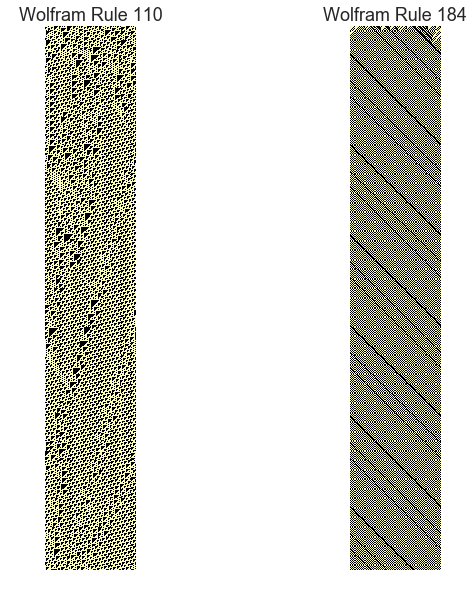

In [24]:
# plotting rule 110 and rule 184

fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].imshow(ca_110,cmap='magma',interpolation='none')
axs[0].axis('off')
axs[0].set_title('Wolfram Rule 110')
axs[1].imshow(ca_184,cmap='magma', interpolation='none')
axs[1].set_title('Wolfram Rule 184')
axs[1].axis('off')

For the local transfer entropy calculation I am going to use a k history value of 16. The reason for the history value being set to 16 is noted in the paper published from Lizer, *Local information transfer as a spatiotemporal filter for complex systems*.

Here is what he mentions about rule 110 using k = 16:

----


*"These plots highlight information transfer
almost exclusively now in the direction of the macroscopic
glider motion, which is even more closely aligned
with our expectations than was seen for k = 6. Importantly,
much less of the gliders are highlighted than for
k = 6 or other techniques, and the larger values of transfer
entropy are concentrated around the leading timeedges
of the gliders. This suggests that the leading glider
edges determine much of the following dynamics which
then comprise mainly non-traveling information."*

----

In [25]:
# calculating local transfer entropy for rule 110 and rule 184 with a k_history value of 16

localTE_110 = teCA(ca_110, 16, "L")
localTE_184 = teCA(ca_184, 16, "L")

(-0.5, 99.5, 600.5, -0.5)

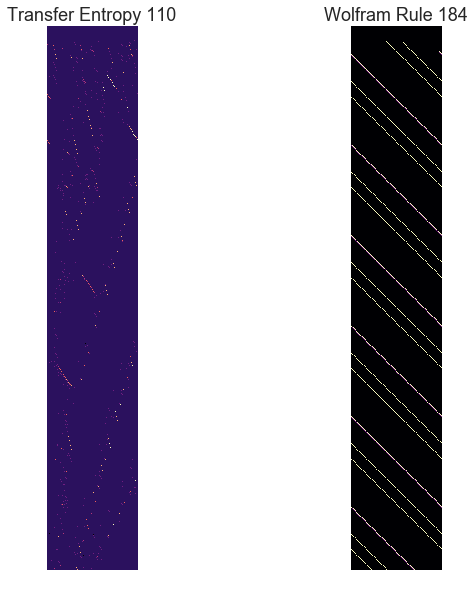

In [26]:
# plotting rule 110 and rule 184 transfer entropy values

fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].imshow(localTE_110,cmap='magma',interpolation='none')
axs[0].axis('off')
axs[0].set_title('Transfer Entropy 110')
axs[1].imshow(localTE_184,cmap='magma', interpolation='none')
axs[1].set_title('Wolfram Rule 184')
axs[1].axis('off')

These two plots above are very interesting as they show that there is not much information transfer dynamics in the CA on the right, but on the left we can see there are much higher values. We can also confirm that where the Transfer Entropy is highest on the left is where the macroscopic direction of the "gliders" are moving. This is able to tell us that gliders are one of the dominant information carriers and influence how the CA develops.

Note that these plots above are only run for 1 trial and would be appropriate to run for 100 trials, average the local transfer entropy matricies, and maybe even add error bars.